In [1]:
# Imports
# ---------

import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
from datetime import timezone

register_matplotlib_converters()

# File locations
# ----------------
the_gases = './oxaria/processed/batch_2_feb21_may21/'
pngs = './oxaria/data/pngs/gap_filling/'

In [2]:
# Load the df
# -------------
oxaria1_gases = pd.read_feather(
    the_gases+'oxaria1_gases_q12021_gf.ftr', use_threads=True).set_index(['tag', 'rec'])
oxaria1_gases_lt = oxaria1_gases.iloc[:, [0, 1, 2, 3, 16, 17, 19]]
del oxaria1_gases

# Checking out the data types
# -----------------------------
oxaria1_gases_lt.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10229024 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:00:04+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-05-31 23:59:50+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   val.no2.wev  float32
 1   val.no2.cnc  float32
 2   val.no2.aev  float32
 3   val.no2.wec  float32
 4   val.sht.hmd  float32
 5   val.sht.tmp  float32
 6   insert_date  object 
dtypes: float32(6), object(1)
memory usage: 734.9+ MB


In [3]:
# Some cleaning incase have missed anything
#-------------------------------------------
oxaria1_gases_lt = oxaria1_gases_lt[~oxaria1_gases_lt.index.duplicated(keep='last')].reset_index()
oxaria1_gases_lt = oxaria1_gases_lt.dropna(axis=0,subset=['tag']).set_index(['tag','rec']).sort_index()

# Start and end dates of unstable operational periods

| Sensor tag         | Start               | End |
|-------------|---------------------|-----|
| scs-bgx-538 | 2021-01-28T00:00:00 | 2021-05-06T00:00:00 |
| scs-bgx-542 | 2021-01-27T12:00:00 | 2021-02-06T23:00:00 |
| scs-bgx-542 | 2021-04-19T09:00:00 | 2021-04-26T00:00:00 |
| scs-bgx-550 | 2021-03-10T12:00:00 | 2021-07-05T00:00:00 |
| scs-bgx-551 | 2021-01-01T00:00:00 | 2021-03-12T00:00:00 |
| scs-bgx-556 | 2021-02-09T12:00:00 | 2021-02-12T23:00:00 |


In [4]:
# Manually select each sensor with an issue then subset to remove the wonky data
# --------------------------------------------------------------------------------
s538 = oxaria1_gases_lt.reset_index().query('tag == "scs-bgx-538"').query(
    'rec <= "2021-04-28T00:00:00+0000" | rec > "2021-05-11T00:00:00+0000"')
s542 = oxaria1_gases_lt.reset_index().query('tag == "scs-bgx-542"').query(
    'rec <= "2021-01-27T12:00:00+0000" | rec > "2021-02-07T23:00:00+0000"')
s542 = s542.query('tag == "scs-bgx-542"').query(
    'rec <= "2021-04-19T09:00:00+0000" | rec > "2021-04-27T00:00:00+0000"')
s550 = oxaria1_gases_lt.reset_index().query('tag == "scs-bgx-550"').query(
    'rec <= "2021-03-10T12:00:00+0000" | rec > "2021-07-05T00:00:00+0000"')
s551 = oxaria1_gases_lt.reset_index().query('tag == "scs-bgx-551"').query(
    'rec <= "2021-01-01T00:00:00+0000" | rec > "2021-03-12T00:00:00+0000"')
s556 = oxaria1_gases_lt.reset_index().query('tag == "scs-bgx-556"').query(
    'rec <= "2021-02-09T12:00:00+0000" | rec > "2021-02-12T23:00:00+0000"')

# Sensors with no issues
# ------------------------
ok_tags = [
    'scs-bgx-536', 'scs-bgx-537', 'scs-bgx-539', 'scs-bgx-540', 'scs-bgx-541',
    'scs-bgx-543'
]

# Select the sensor records with tags in this list
# --------------------------------------------------
sother = oxaria1_gases_lt.reset_index().query('tag in @ok_tags')

# Recombine
# -----------
oxaria1_gases_lt1 = pd.concat([sother, s538, s542]).set_index(['tag', 'rec'])

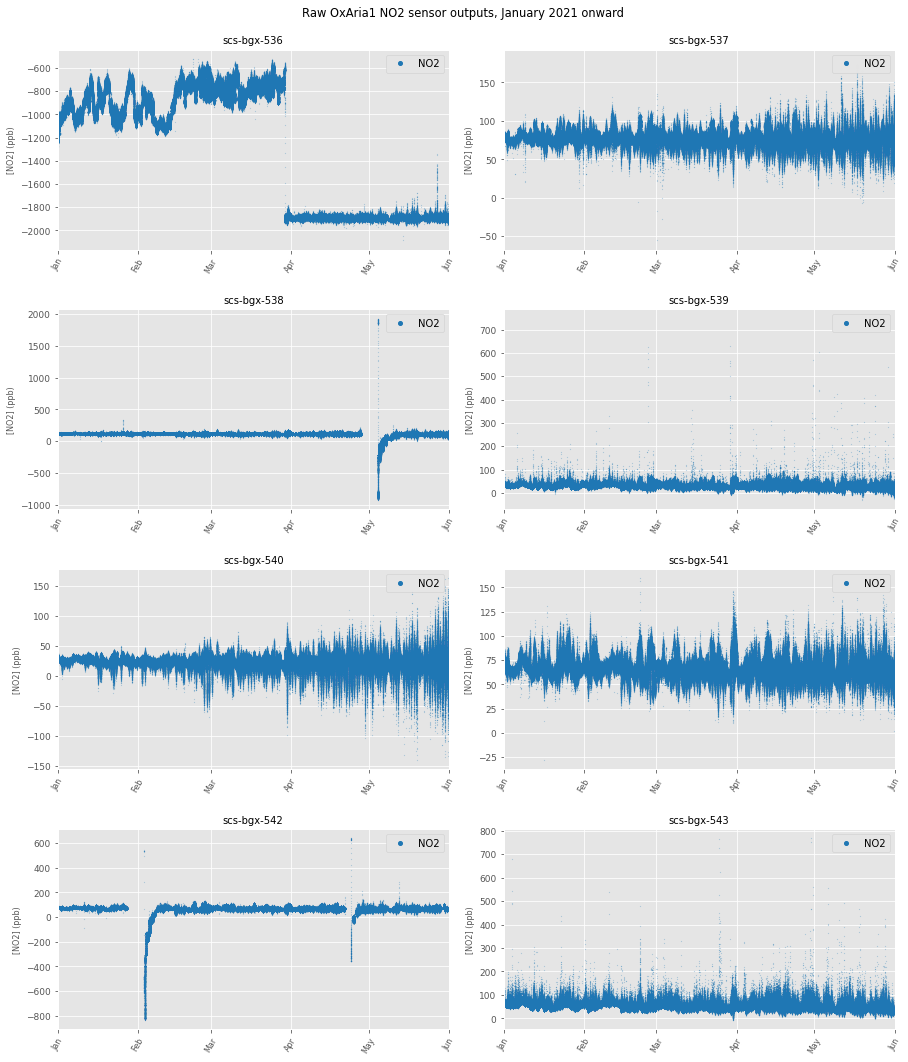

In [5]:
# Check on the outliers & start-ups in the original dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
# plt.tight_layout()
myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 6, 1)

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria1 NO2 sensor outputs, January 2021 onward',
             fontsize=11.5, y=0.91)

for tag, dat in oxaria1_gases_lt.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue', linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True,
             zorder=1)
    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right')

plt.show()

for ax in axes_list:
    ax.remove()

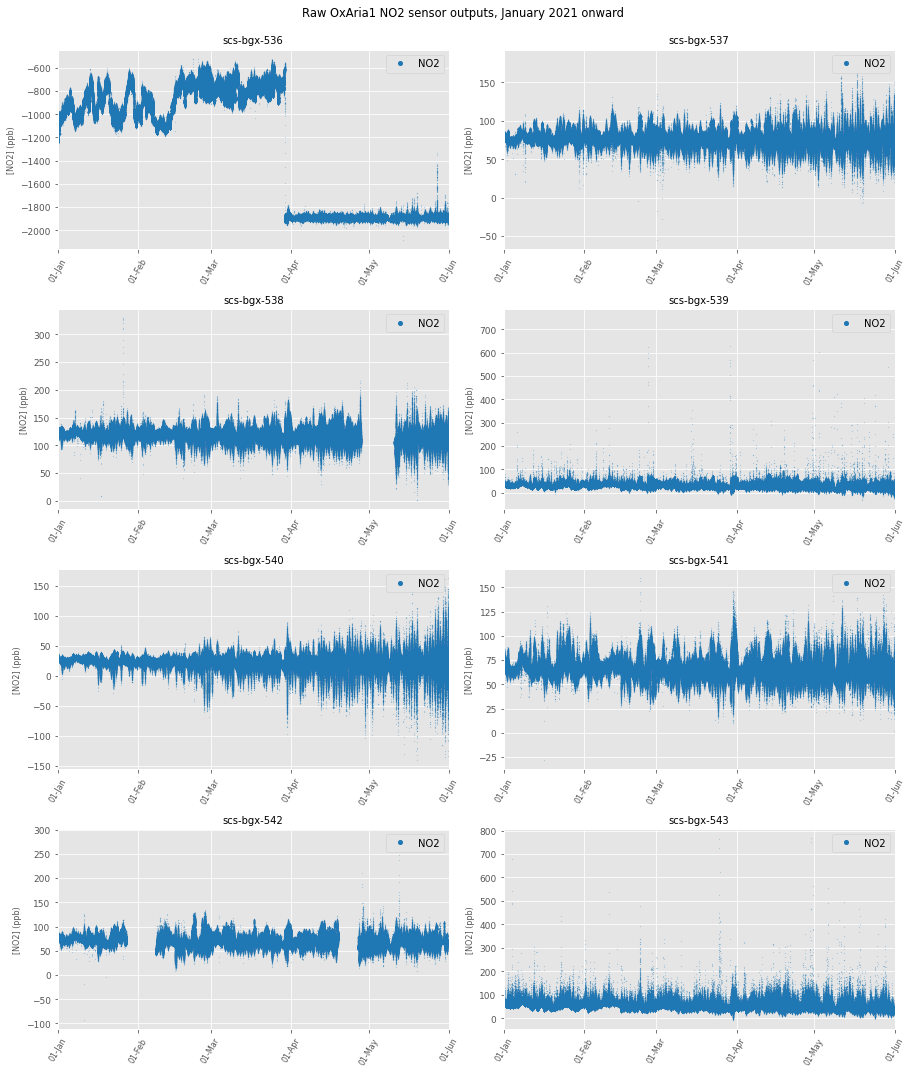

In [6]:
# Check on the outliers & start-ups in the filtered dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 6, 1)

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria1 NO2 sensor outputs, January 2021 onward',
             fontsize=11.5, y=0.91)

for tag, dat in oxaria1_gases_lt1.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue', linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True,
             zorder=1)
    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right')

plt.show()

for ax in axes_list:
    ax.remove()

In [7]:
# Apply empirical filters
# -------------------------
cols = ['val.no2.cnc']

condition = ((oxaria1_gases_lt1['val.sht.tmp'] < -10.0) |
             (oxaria1_gases_lt1['val.sht.tmp'] > 35.0) |
             (oxaria1_gases_lt1['val.sht.hmd'] < 35.0))

for col in cols:
    oxaria1_gases_lt1[col +
                      '_1'] = np.where(condition, np.nan, oxaria1_gases_lt1[col])

# Save to feather
# -----------------
oxaria1_gases_lt1.reset_index().to_feather(
    the_gases+'oxaria1_gases_stable_536_q12021.ftr')